In [1]:
import tensorflow as tf # tensorflow 2.10
import numpy as np
import matplotlib.pyplot as plt
from load_data2 import evals_parser, evals_square_parser, evecs_parser

2022-10-14 23:08:25.135198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 23:08:25.323520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-14 23:08:25.323551: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-14 23:08:25.357662: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-14 23:08:26.460784: W tensorflow/stream_executor/platform/de

In [2]:
# Importing the datasets
batch_size = 16
tfile = "/home/gaspard/ETHZ/Master_Arbeit/acoupipe_datasets/training_1-100000_csmtriu_1src_he4.0625-1393.4375Hz_ds1-v001_13-Sep-2022.tfrecord"
dataset = tf.data.TFRecordDataset(filenames=[tfile])

evals_dataset = dataset.map(evals_parser)
evals_dataset = evals_dataset.shuffle(buffer_size=10).batch(batch_size)

evals_square_dataset = dataset.map(evals_square_parser)
evals_square_dataset = evals_square_dataset.shuffle(buffer_size=10).batch(batch_size)

evecs_dataset = dataset.map(evecs_parser)
evecs_dataset = evecs_dataset.shuffle(buffer_size=10).batch(batch_size)

2022-10-14 23:08:28.513238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-14 23:08:28.513277: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-14 23:08:28.513296: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gaspard-HP-ZBook-15u-G2): /proc/driver/nvidia/version does not exist
2022-10-14 23:08:28.513565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### WGANGP to generate eigenvalues

In [3]:
from evals_WGANGP2 import evals_WGANGP

# Creating GAN
evals_wgangp = evals_WGANGP()

/home/gaspard/anaconda3/envs/master_arbeit/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


-=-=- EPOCH 1 -=-=-
>loss: [c=2.400][g=-1.119]
>accuracy: [c=0.500][g=0.062]

-=-=- EPOCH 2 -=-=-
>loss: [c=6.473][g=-0.882]
>accuracy: [c=0.500][g=0.188]

-=-=- EPOCH 3 -=-=-
>loss: [c=1.810][g=-0.718]
>accuracy: [c=0.500][g=0.188]

-=-=- EPOCH 4 -=-=-
>loss: [c=4.410][g=-0.909]
>accuracy: [c=0.500][g=0.250]

-=-=- EPOCH 5 -=-=-
>loss: [c=-0.683][g=-0.395]
>accuracy: [c=0.500][g=0.250]

-=-=- EPOCH 6 -=-=-
>loss: [c=12.891][g=-0.490]
>accuracy: [c=0.500][g=0.312]

-=-=- EPOCH 7 -=-=-
>loss: [c=15.560][g=-0.252]
>accuracy: [c=0.500][g=0.438]

-=-=- EPOCH 8 -=-=-
>loss: [c=30.790][g=-0.591]
>accuracy: [c=0.500][g=0.250]

-=-=- EPOCH 9 -=-=-
>loss: [c=-0.450][g=-0.621]
>accuracy: [c=0.500][g=0.188]

-=-=- EPOCH 10 -=-=-
>loss: [c=0.017][g=-0.449]
>accuracy: [c=0.500][g=0.312]

-=-=- EPOCH 11 -=-=-
>loss: [c=5.624][g=-0.298]
>accuracy: [c=0.500][g=0.375]

-=-=- EPOCH 12 -=-=-
>loss: [c=2.189][g=-0.853]
>accuracy: [c=0.500][g=0.125]

-=-=- EPOCH 13 -=-=-
>loss: [c=18.137][g=-0.604]
>accura

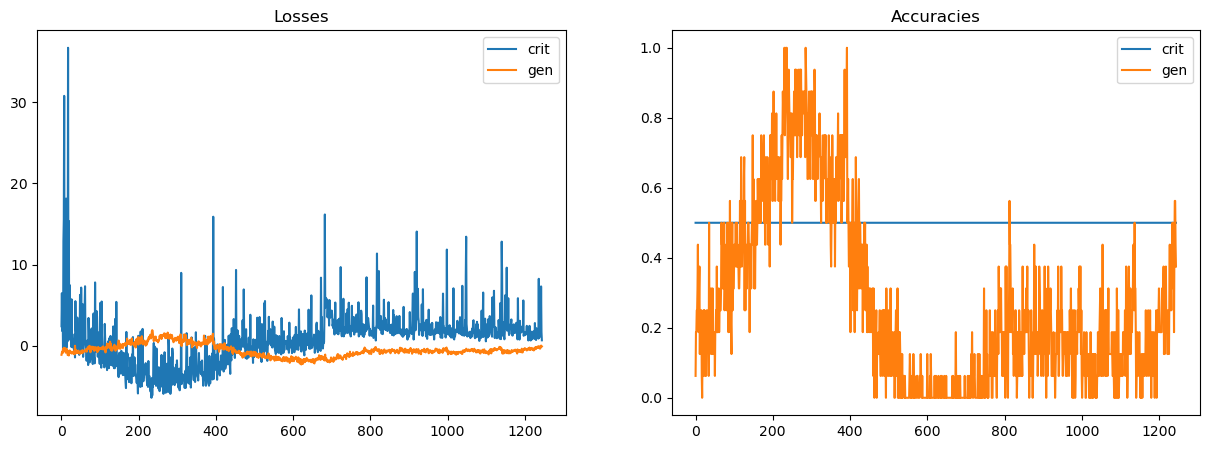

In [4]:
evals_wgangp.train(evals_dataset=evals_square_dataset, n_epoch=1245)

1/1 [==============================] - 0s 162ms/step
tf.Tensor(-0.10031088, shape=(), dtype=float32)
1/1 [==============================] - 0s 27ms/step
tf.Tensor(0.022726323, shape=(), dtype=float32)
real eigenvalues found


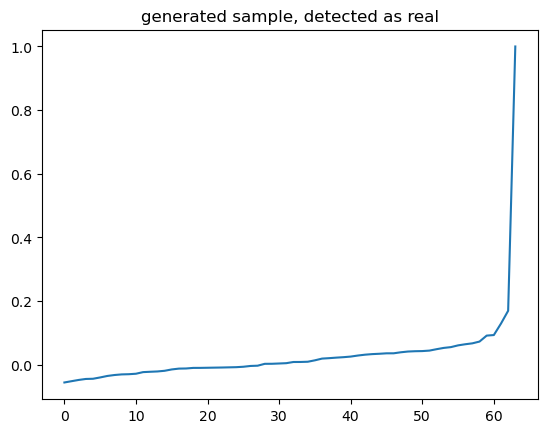

In [5]:
import numpy as np
import matplotlib.pyplot as plt

is_real, sample = evals_wgangp.generate_evals()
sample = np.sort(np.array(sample[0, :, :, 0]).flatten()) # convert sample from (1,8,8,1) to (64,)


if is_real:
    plt.title("generated sample, detected as real")
    plt.plot(sample)
else:
    plt.title("generated sample, detected as fake")
    plt.plot(sample)    

### GRIDSEARCH: GAN to generate eigenvalues

In [ ]:
from tensorflow import summary
from evals_GAN2 import evals_GAN

lr_list = [5e-7, 1e-7, 5e-8, 1e-8, 5e-9, 1e-9]
#lr_list = [1e-10, 1e-11, 1e-12]
beta_1_list = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

for lr in lr_list:
    for beta_1 in beta_1_list:
        
        print(f"lr={lr}, beta_1={beta_1}")
        
        evals_gan = evals_GAN(lr, beta_1, summary=False) # Creating GAN
        evals_gan.train(evals_dataset=evals_dataset, n_epoch=500, print_epoch=False) # Training the GAN

        # Plotting sampled eigenvalues 
        is_real, sample = evals_gan.get_evals()
        
        fig = plt.figure()

        if is_real:
            plt.title(f"generated sample, detected as real, lr={lr}, b={beta_1}")
            plt.plot(np.sort(np.array(sample)[0]))
        else:
            plt.title(f"generated sample, detected as fake, lr={lr}, b={beta_1}")
            plt.plot(np.sort(np.array(sample)[0]))

In [ ]:
# Grid search 2
#from tensorflow import summary
from evals_GAN2 import evals_GAN

lr_list = [1e-9, 1e-9, 1e-8, 1e-7, 1e-7]
beta_1_list = [0.5, 0.7, 0.2, 0.1, 0.9]

n_epoch=250

for lr, beta_1 in zip(lr_list, beta_1_list):
    
    print(f"lr={lr}, beta_1={beta_1}")
    
    evals_gan = evals_GAN(lr, beta_1, summary=False) # Creating GAN
    evals_gan.train(evals_dataset=evals_dataset, n_epoch=n_epoch, print_epoch=False) # Training the GAN

    # Plotting sampled eigenvalues 
    is_real, sample = evals_gan.get_evals()
    
    fig = plt.figure()

    if is_real:
        plt.title(f"generated sample, detected as real, lr={lr}, b={beta_1}")
        plt.plot(np.sort(np.array(sample)[0]))
    else:
        plt.title(f"generated sample, detected as fake, lr={lr}, b={beta_1}")
        plt.plot(np.sort(np.array(sample)[0]))
    
# runtime   : 1000 epochs  : approx 5min30
# runtime   : 250 epochs   : approx 1min30

### GAN to generate eigenvalues

In [ ]:
from evals_GAN2 import evals_GAN

# Creating GAN
evals_gan = evals_GAN()

# Training the GAN
evals_gan.train(evals_dataset=evals_dataset, n_epoch=100)

In [ ]:
# Plotting sampled eigenvalues 
is_real, sample = evals_gan.get_evals()

if is_real:
    plt.title("generated sample, detected as real")
    plt.plot(np.sort(np.array(sample)[0]))
else:
    plt.title("generated sample, detected as fake")
    plt.plot(np.sort(np.array(sample)[0]))

### DCGAN to generate eigenvalues

In [ ]:
from evals_DCGAN2 import evals_DCGAN

# Creating GAN
evals_dcgan = evals_DCGAN()

# Training the GAN
evals_dcgan.train(evals_dataset=evals_dataset, n_epoch=300)

In [ ]:
# Plotting sampled eigenvalues 
is_real, sample = evals_dcgan.get_evals()

if is_real:
    plt.title("generated sample, detected as real")
    plt.plot(np.sort(np.array(sample)[0]))
else:
    plt.title("generated sample, detected as fake")
    plt.plot(np.sort(np.array(sample)[0]))

### WGAN to generate eigenvectors 

In [ ]:
from evecs_WGAN2 import evecs_WGAN

# Creating WGAN
evecs_wgan = evecs_WGAN()

In [ ]:
evecs_wgan.train(evecs_dataset=evecs_dataset, n_epoch=1000)

In [ ]:
sample = evecs_wgan.get_evecs()